In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cp

In [3]:
sns.set_theme(context="notebook")

## Import data

In [4]:
def get_demand_mask_and_price(df, colName, dt):
    col = df[colName].to_numpy() / dt
    mask = col > 0
    price = col[mask][0]
    return mask, price

In [5]:
##### loads
df = pd.read_csv("site1_load.csv")
dt = 1/4 # in hours
powerLoad, heatLoad = df['Power Load [kWh]'].to_numpy(), df['Heat Load [kWh]'].to_numpy()

##### prices
df = pd.read_csv("power_price_B20.csv")
energyPricePower = df["energyPrice"].to_numpy()
# from per kW to per kWh in 15 minutes
powerDemand = [get_demand_mask_and_price(df, colName, dt) for colName in ["peakDemandSummerPrice",
                                                                          "partialPeakDemandSummerPrice",
                                                                          "demandSummerPrice",
                                                                          "peakDemandWinterPrice",
                                                                          "demandWinterPrice"]]
df = pd.read_csv("gas_price.csv")
energyPriceGas = df["energyPrice"].to_numpy()

##### emissions
df = pd.read_csv("power_grid_emissions.csv")
df.ffill(inplace=True)
emissionsPower = df["MOER version 2.0"].to_numpy()
df = pd.read_csv("gas_emissions.csv")
emissionsGas = df["gasEmissions"].to_numpy()

# clear memory
del df

In [6]:
n = len(powerLoad)

# set up dictionnary to store different scenarios
all_Costs = {} # $/year
all_Emissions = {} # kCO2/year
all_LCOE = {} # $/kWh
all_LCOS = {} # $/kWh? or prefer $/kW?

## 0. Baseline

We only have a natural gas furnace to supply heat, and no storage.

In [17]:
##### variables and parameters
# financial
CRF = cp.Parameter(nonneg=True) # capital recovery factor TBD
# gas furnace
gasInputGF = cp.Variable(n, nonneg=True)
capaGF = cp.Variable(nonneg=True) # kW
capaPriceGF = cp.Parameter(nonneg=True) # $/kW TBD
effGF = cp.Parameter(nonneg=True) # %

##### useful quantities
# gas furnace
heatOutputGF = effGF*gasInputGF
# consumption
gasConsumption = gasInputGF
powerConsumption = powerLoad + 0 # no heat pump or batteries here
# loads
heatSupply = heatOutputGF
# costs
opexPower = energyPricePower@powerConsumption + np.sum([cp.max(powerConsumption[d[0]])*d[1] for d in powerDemand])
opexGas = energyPriceGas@gasConsumption
opex = opexPower + opexGas
capexGF = capaGF*capaPriceGF
capex = capexGF
# emissions
emissions = emissionsPower@powerConsumption + emissionsGas@gasConsumption

# derived quantities
LCOE = (opex + CRF*capex) / (np.sum(powerLoad) + np.sum(heatLoad))
LCOS = 0.0 # no storage

##### constraints
cons = []
# meet load
cons += [heatSupply == heatLoad]
# gas furnace
cons += [heatOutputGF <= capaGF*dt]                                

##### objective function
obj = cp.Minimize(opex + CRF*capex)

#### solve problem
CRF.value = 1/20 # % TBD
capaPriceGF.value =  200 # $/kW TBD
effGF.value = 0.85 # %
prob = cp.Problem(obj, cons)
prob.solve(solver=cp.MOSEK)
print(prob.status)
print('Cost: {:.0f} $/year'.format(obj.value))
print('Emissions: {:.0f} kgCO2/year'.format(emissions.value))
print('Gas Furnace capacity: {:.0f} kW'.format(capaGF.value))
print('LCOE: {:.2f} $/kWh'.format(LCOE.value))

baseline_cost = obj.value
baseline_emissions = emissions.value

all_Costs['Baseline'] = baseline_cost
all_Emissions['Baseline'] = baseline_emissions
all_LCOE['Baseline'] = LCOE.value
all_LCOS['Baseline'] = LCOS

optimal
cost = 5674230.0 $ per year
emissions = 16043137.0 kgCO2 per year
Gas Furnace capacity = 35748.0 kW


## 1. Natural gas & heat pump

Natural gas furnace and heat pump

In [31]:
##### variables and parameters
# financial
CRF = cp.Parameter(nonneg=True) # capital recovery factor TBD
# gas furnace
gasInputGF = cp.Variable(n, nonneg=True)
capaGF = cp.Variable(nonneg=True) # kW
capaPriceGF = cp.Parameter(nonneg=True) # $/kW TBD
effGF = cp.Parameter(nonneg=True) # %
# heat pump
powerInputHP = cp.Variable(n, nonneg=True)
capaHP = cp.Variable(nonneg=True) # kW
copHP = cp.Parameter(nonneg=True) # % TBD
capaPriceHP = cp.Parameter(nonneg=True) # $/kW TBD
#should add ramp rates maybe ?

##### useful quantities
# gas furnace
heatOutputGF = effGF*gasInputGF
# heat pump
heatOutputHP = copHP*powerInputHP
# consumption
gasConsumption = gasInputGF
powerConsumption = powerLoad + powerInputHP
# loads
heatSupply = heatOutputGF + heatOutputHP
# costs
opexPower = energyPricePower@powerConsumption + np.sum([cp.max(powerConsumption[d[0]])*d[1] for d in powerDemand])
opexGas = energyPriceGas@gasConsumption
opex = opexPower + opexGas
capexGF = capaGF*capaPriceGF
capexHP = capaHP*capaPriceHP
capex = capexGF + capexHP
# emissions
emissions = emissionsPower@powerConsumption + emissionsGas@gasConsumption

# derived quantities
LCOE = (opex + CRF*capex) / (np.sum(powerLoad) + np.sum(heatLoad))
LCOS = 0.0 # no storage

##### constraints
cons = []
# meet load
cons += [heatSupply == heatLoad]                                  
# reduce emissions
cons += [emissions <= 0.7*baseline_emissions] # 30% reduction
# gas furnace
cons += [heatOutputGF <= capaGF*dt]
# heat pump
cons += [heatOutputHP <= capaHP*dt]   

##### objective function
obj = cp.Minimize(opex + CRF*capex)

#### solve problem
CRF.value = 1/20 # % TBD
capaPriceGF.value =  200 # $/kW TBD
effGF.value = 0.85 # %
copHP.value = 3 # TBD
capaPriceHP.value =  1000 # $/kW TBD
prob = cp.Problem(obj, cons)
prob.solve(solver=cp.MOSEK)
print(prob.status)
print('Cost: {:.0f} $/year ({:.2f} % increase relative to baseline)'.format(obj.value, 100*(obj.value-baseline_cost)/baseline_cost))
print('Emissions: {:.0f} kgCO2/year ({:.2f} % reduction relative to baseline)'.format(emissions.value, -100*(emissions.value-baseline_emissions)/baseline_emissions))
print('Gas furnace capacity: {:.0f} kW'.format(capaGF.value))
print('Heat pump capacity: {:.0f} kW'.format(capaHP.value))
print('LCOE: {:.2f} $/kWh'.format(LCOE.value))

all_Costs['NG+HP'] = obj.value
all_Emissions['NG+HP'] = emissions.value
all_LCOE['NG+HP'] = LCOE.value
all_LCOS['NG+HP'] = LCOS

optimal
cost = 5966389.0 $ per year ( 5.15 % relative to baseline)
emissions = 11230196.0 kgCO2 per year ( -30.0 % relative to baseline)
gas furnace capacity = 27207.0 kW
heat pump capacity = 8541.0 kW


## 2. Natural gas, heat pump and battery

Natural gas furnace and heat pump and battery

In [32]:
##### variables and parameters
# financial
CRF = cp.Parameter(nonneg=True) # capital recovery factor TBD
# gas furnace
gasInputGF = cp.Variable(n, nonneg=True)
capaGF = cp.Variable(nonneg=True) # kW
capaPriceGF = cp.Parameter(nonneg=True) # $/kW TBD
effGF = cp.Parameter(nonneg=True) # %
# heat pump
powerInputHP = cp.Variable(n, nonneg=True)
capaHP = cp.Variable(nonneg=True) # kW
copHP = cp.Parameter(nonneg=True) # % TBD
capaPriceHP = cp.Parameter(nonneg=True) # $/kW TBD
#should add ramp rates maybe ?
# battery
powerChargeB = cp.Variable(n) # kWh >0 when charge
stateOfChargeB = cp.Variable(n+1, nonneg=True) # kWh
powerCapaB = cp.Variable(nonneg=True) # kW we will fix 4h storage for the battery, should be a parameter we can change with various prices. will do later.
powerCapaPriceB = cp.Parameter(nonneg=True) # $/kW

##### useful quantities
# gas furnace
heatOutputGF = effGF*gasInputGF
# heat pump
heatOutputHP = copHP*powerInputHP
# battery
energyCapaB = 4*powerCapaB
# consumption
gasConsumption = gasInputGF
powerConsumption = powerLoad + powerInputHP + powerChargeB
# loads
heatSupply = heatOutputGF + heatOutputHP
# costs
opexPower = energyPricePower@powerConsumption + np.sum([cp.max(powerConsumption[d[0]])*d[1] for d in powerDemand])
opexGas = energyPriceGas@gasConsumption
opex = opexPower + opexGas
capexGF = capaGF*capaPriceGF
capexHP = capaHP*capaPriceHP
capexB = powerCapaB*powerCapaPriceB
capex = capexGF + capexHP + capexB
# emissions
emissions = emissionsPower@powerConsumption + emissionsGas@gasConsumption

##### constraints
cons = []
# meet load
cons += [heatSupply == heatLoad]                                  
# reduce emissions
cons += [emissions <= 0.7*baseline_emissions] # 30% reduction
# gas furnace
cons += [heatOutputGF <= capaGF*dt]
# heat pump
cons += [heatOutputHP <= capaHP*dt]
# battery
cons += [powerChargeB <= powerCapaB*dt]
cons += [-powerCapaB*dt <= powerChargeB]
cons += [stateOfChargeB <= energyCapaB]
cons += [stateOfChargeB[1:] == stateOfChargeB[:-1] + powerChargeB*dt]
cons += [powerConsumption >= 0] # no selling back to the grid

##### objective function
obj = cp.Minimize(opex + CRF*capex)

#### solve problem
CRF.value = 1/20 # % TBD
capaPriceGF.value =  200 # $/kW TBD
effGF.value = 0.85 # %
copHP.value = 3 # TBD
capaPriceHP.value =  1000 # $/kW TBD
powerCapaPriceB.value = 1900 # $/kW TBD
prob = cp.Problem(obj, cons)
prob.solve(solver=cp.MOSEK)
print(prob.status)
print('cost =', np.round(obj.value), "$ per year", "(", np.round(100*(obj.value-baseline_cost)/baseline_cost, 2), "% relative to baseline)")
print('emissions =', np.round(emissions.value), "kgCO2 per year", "(", np.round(100*(emissions.value-baseline_emissions)/baseline_emissions, 2), "% relative to baseline)")
print('gas furnace capacity =', np.round(capaGF.value), "kW")
print('heat pump capacity =', np.round(capaHP.value), "kW")
print('battery capacity =', np.round(powerCapaB.value), "kW")
# TODO LCOS and LCOE, same for emissions

optimal
cost = 5361008.0 $ per year ( -5.52 % relative to baseline)
emissions = 11230196.0 kgCO2 per year ( -30.0 % relative to baseline)
gas furnace capacity = 31171.0 kW
heat pump capacity = 4577.0 kW
battery capacity = 5405.0 kW


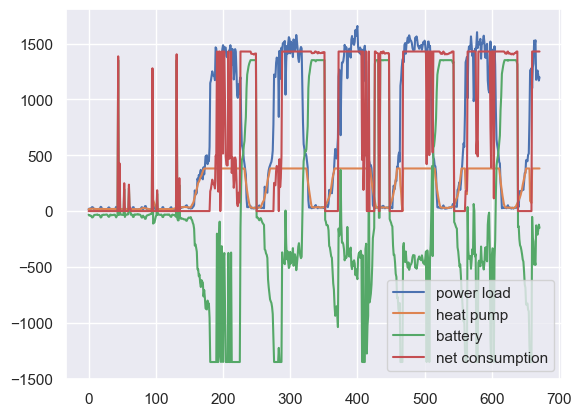

In [30]:
plt.plot(powerLoad[:24*4*7], label='power load')
plt.plot(powerInputHP.value[:24*4*7], label='heat pump')
plt.plot(powerChargeB.value[:24*4*7], label='battery')
plt.plot(powerConsumption.value[:24*4*7], label='net consumption')
plt.legend()
plt.show()

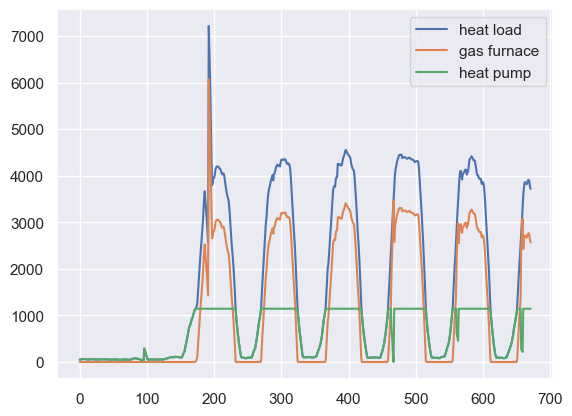

In [33]:
plt.plot(heatLoad[:24*4*7], label='heat load')
plt.plot(heatOutputGF.value[:24*4*7], label='gas furnace')
plt.plot(heatOutputHP.value[:24*4*7], label='heat pump')
plt.legend()
plt.show()

## 3. Electricity & heat pump
Only to have an idea

In [ ]:
##### Variables
powerInputHP = cp.Variable(n, nonneg=True)

#### Parameters
# financial
CRF = cp.Parameter(nonneg=True) # capital recovery factor TBD
# heat pump
copHP = cp.Parameter(nonneg=True) # % TBD
capaPriceHP = cp.Parameter(nonneg=True) # $/kW TBD
# emission target (% of baseline emissions)
emissionTarget = cp.Parameter(nonneg=True)

##### useful quantities
# heat pump
heatOutputHP = copHP*powerInputHP
capaHP = cp.max(heatOutputHP / dt)
# consumption
powerConsumption = powerLoad + powerInputHP
# loads
heatSupply = heatOutputHP
# costs
opexPower = energyPricePower@powerConsumption + np.sum([cp.max(powerConsumption[d[0]])*d[1] for d in powerDemand])
opex = opexPower
capexHP = capaHP*capaPriceHP
capex = capexHP
# emissions
emissions = emissionsPower@powerConsumption

# derived quantities
LCOE = (opex + CRF*capex) / (np.sum(powerLoad) + np.sum(heatLoad))
LCOS = 0.0 # no storage

##### constraints
cons = []
# meet load
cons += [heatSupply == heatLoad]                                  
# reduce emissions
cons += [emissions <= emissionTarget * baseline_emissions] 

##### objective function
obj = cp.Minimize(opex + CRF*capex)

#### solve problem
CRF.value = 1/20 # % TBD
copHP.value = 3 # TBD
capaPriceHP.value =  1000 # $/kW TBD
emissionTarget.value = 0.7 # TBD

prob = cp.Problem(obj, cons)
prob.solve(solver=cp.CLARABEL)
print(prob.status)
print('Cost: {:.0f} $/year ({:.2f} % increase relative to baseline)'.format(obj.value, 100*(obj.value-baseline_cost)/baseline_cost))
print('Emissions: {:.0f} kgCO2/year ({:.2f} % reduction relative to baseline)'.format(emissions.value, -100*(emissions.value-baseline_emissions)/baseline_emissions))
print('Heat pump capacity: {:.0f} kW'.format(capaHP.value))
print('LCOE: {:.2f} $/kWh'.format(LCOE.value))

all_Costs['Electricity+HP'] = obj.value
all_Emissions['Electricity+HP'] = emissions.value
all_LCOE['Electricity+HP'] = LCOE.value
all_LCOS['Electricity+HP'] = LCOS

## 4. Electricity, heat pump and battery storage

Include capacity battery in kWh in optimization variables. Assume the energy stored in the battery can be used to meet power load only. 

Not sure about the def of LCOS here.

In [ ]:
##### Variables
powerInputHP = cp.Variable(n, nonneg=True) # kWh
powerInputBatt = cp.Variable(n) # kWh, positive when it charges, negative when it discharges
socBatt = cp.Variable(n, nonneg=True) # kWh
capaBatt = cp.Variable(nonneg=True) # kWh

#### Parameters
# financial
CRF = cp.Parameter(nonneg=True) # capital recovery factor TBD
# heat pump
copHP = cp.Parameter(nonneg=True) # % TBD
capaPriceHP = cp.Parameter(nonneg=True) # $/kW TBD
# battery
capaPriceBatt = cp.Parameter(nonneg=True) # $/kWh TBD
socMinBatt = cp.Parameter(nonneg=True) # kWh
socIniBatt = cp.Parameter(nonneg=True) # initial
socFinBatt = cp.Parameter(nonneg=True) # final
maxDischargeRateBatt = cp.Parameter(nonneg=True) # kW
maxChargeRateBatt = cp.Parameter(nonneg=True) # kW
# emission target (% of baseline emissions)
emissionTarget = cp.Parameter(nonneg=True)

##### useful quantities
# heat pump
heatOutputHP = copHP*powerInputHP
capaHP = cp.max(heatOutputHP / dt) # kW
# consumption
powerConsumption = powerLoad + powerInputBatt + powerInputHP 
# loads
heatSupply = heatOutputHP
# costs
opexPower = energyPricePower@cp.pos(powerConsumption) + np.sum([cp.max(cp.pos(powerConsumption)[d[0]])*d[1] for d in powerDemand])
opex = opexPower
capexHP = capaHP*capaPriceHP 
capexBatt = capaBatt*capaPriceBatt
capex = capexHP + capexBatt
# emissions
emissions = emissionsPower@powerConsumption

# derived quantities
LCOE = (opex + CRF*capex) / (np.sum(powerLoad) + np.sum(heatLoad))
LCOS = (CRF*capexBatt) / capaBatt # take into account energy saved by storage?

##### constraints
cons = []
# meet load
cons += [heatSupply == heatLoad]                                  
# reduce emissions
cons += [emissions <= emissionTarget * baseline_emissions] 
# battery operation
cons += [-powerInputBatt <= maxDischargeRateBatt*capaBatt*dt]
cons += [powerInputBatt <= maxChargeRateBatt*capaBatt*dt]
cons += [socBatt >= socMinBatt]
cons += [socBatt <= capaBatt]
cons += [socBatt[0] == socIniBatt]
cons += [socBatt[-1] == socFinBatt]
for t in range(n-1):
    cons += [socBatt[t+1] == socBatt[t] + powerInputBatt[t]]

##### objective function
obj = cp.Minimize(opex + CRF*capex)

#### solve problem
CRF.value = 1/20 # % TBD
copHP.value = 3 # TBD
capaPriceHP.value =  1000 # $/kW TBD
capaPriceBatt.value = 200 # $/kWh TBD
socMinBatt.value = 0 # kWh
socIniBatt.value = 0 # kWh
socFinBatt.value = 0 # kWh
maxDischargeRateBatt.value = 1 # /h. A rate of 2 (2C) indicates it can discharge all its energy capacity in 1/2 hour
maxChargeRateBatt.value = 1 # /h. A rate of 2 (2C) indicates it can charge all its energy capacity in 1/2 hour
emissionTarget.value = 0.7 # TBD

prob = cp.Problem(obj, cons)
prob.solve(solver=cp.CLARABEL)
print(prob.status)
print('Cost: {:.0f} $/year ({:.2f} % increase relative to baseline)'.format(obj.value, 100*(obj.value-baseline_cost)/baseline_cost))
print('Emissions: {:.0f} kgCO2/year ({:.2f} % reduction relative to baseline)'.format(emissions.value, -100*(emissions.value-baseline_emissions)/baseline_emissions))
print('Heat pump capacity: {:.0f} kW'.format(capaHP.value))
print('Battery capacity: {:.0f} kW'.format(capaBatt.value))
print('LCOE: {:.2f} $/kWh'.format(LCOE.value))
print('LCOS: {:.2f} $/kWh'.format(LCOS.value))

all_Costs['Electricity+HP+Battery'] = obj.value
all_Emissions['Electricity+HP+Battery'] = emissions.value
all_LCOE['Electricity+HP+Battery'] = LCOE.value
all_LCOS['Electricity+HP+Battery'] = LCOS.value

## 5. Electricity, heat pump, battery and thermal storage

First assumption simple for thermal storage (same operation as a battery)

In [ ]:
##### Variables
powerInputHP = cp.Variable(n, nonneg=True) # kWh
powerInputBatt = cp.Variable(n) # kWh, positive when it charges, negative when it discharges
socBatt = cp.Variable(n, nonneg=True) # kWh
capaBatt = cp.Variable(nonneg=True) # kWh
# Add thermal storage
heatInputThS = cp.Variable(n) # kWh, positive when it charges, negative when it discharges
socThS = cp.Variable(n, nonneg=True) # kWh
capaThS = cp.Variable(nonneg=True) # kWh

#### Parameters
# financial
CRF = cp.Parameter(nonneg=True) # capital recovery factor TBD
# heat pump
copHP = cp.Parameter(nonneg=True) # % TBD
capaPriceHP = cp.Parameter(nonneg=True) # $/kW TBD
# battery
capaPriceBatt = cp.Parameter(nonneg=True) # $/kWh TBD
socMinBatt = cp.Parameter(nonneg=True) # kWh
socIniBatt = cp.Parameter(nonneg=True) # initial
socFinBatt = cp.Parameter(nonneg=True) # final
maxDischargeRateBatt = cp.Parameter(nonneg=True) # kW
maxChargeRateBatt = cp.Parameter(nonneg=True) # kW
# thermal storage
capaPriceThS = cp.Parameter(nonneg=True) # $/kWh TBD
socMinThS = cp.Parameter(nonneg=True) # kWh
socIniThS = cp.Parameter(nonneg=True) # initial
socFinThS = cp.Parameter(nonneg=True) # final
maxDischargeRateThS = cp.Parameter(nonneg=True) # kW
maxChargeRateThS = cp.Parameter(nonneg=True) # kW
# emission target (% of baseline emissions)
emissionTarget = cp.Parameter(nonneg=True)

##### useful quantities
# heat pump
heatOutputHP = copHP*powerInputHP
capaHP = cp.max(heatOutputHP / dt) # kW
# consumption
powerConsumption = powerLoad + powerInputBatt + powerInputHP
# load
heatSupply = heatOutputHP - heatInputThS
# costs
opexPower = energyPricePower@cp.pos(powerConsumption) + np.sum([cp.max(cp.pos(powerConsumption)[d[0]])*d[1] for d in powerDemand])
opex = opexPower
capexHP = capaHP*capaPriceHP 
capexBatt = capaBatt*capaPriceBatt
capexThS = capaThS*capaPriceThS
capex = capexHP + capexBatt + capexThS
# emissions
emissions = emissionsPower@powerConsumption

# derived quantities
LCOE = (opex + CRF*capex) / (np.sum(powerLoad) + np.sum(heatLoad))
LCOS = (CRF*capexBatt+ CRF*capexThS) / (capaBatt+capaThS) # bof definition

##### constraints
cons = []
# meet load
cons += [heatSupply == heatLoad]                                  
# reduce emissions
cons += [emissions <= emissionTarget * baseline_emissions] 
# battery operation
cons += [-powerInputBatt <= maxDischargeRateBatt*capaBatt*dt]
cons += [powerInputBatt <= maxChargeRateBatt*capaBatt*dt]
cons += [socBatt >= socMinBatt]
cons += [socBatt <= capaBatt]
cons += [socBatt[0] == socIniBatt]
cons += [socBatt[-1] == socFinBatt]
for t in range(n-1):
    cons += [socBatt[t+1] == socBatt[t] + powerInputBatt[t]]
# thermal storage operation
cons += [-heatInputThS <= maxDischargeRateThS*capaThS*dt]
cons += [heatInputThS <= maxChargeRateThS*capaThS*dt]
cons += [socThS >= socMinThS]
cons += [socThS <= capaThS]
cons += [socThS[0] == socIniThS]
cons += [socThS[-1] == socFinThS]
for t in range(n-1):
    cons += [socThS[t+1] == socThS[t] + heatInputThS[t]]

##### objective function
obj = cp.Minimize(opex + CRF*capex)

#### solve problem
CRF.value = 1/20 # % TBD
copHP.value = 3 # TBD
capaPriceHP.value =  1000 # $/kW TBD
capaPriceBatt.value = 200 # $/kWh TBD
socMinBatt.value = 0 # kWh
socIniBatt.value = 0 # kWh
socFinBatt.value = 0 # kWh
maxDischargeRateBatt.value = 1 # /h. A rate of 2 (2C) indicates it can discharge all its energy capacity in 1/2 hour
maxChargeRateBatt.value = 1 # /h. A rate of 2 (2C) indicates it can charge all its energy capacity in 1/2 hour
capaPriceThS.value = 30 # $/kWh TBD
socMinThS.value = 0 # kWh
socIniThS.value = 0 # kWh
socFinThS.value = 0 # kWh
maxDischargeRateThS.value = 1
maxChargeRateThS.value = 1 
emissionTarget.value = 0.7 # TBD

prob = cp.Problem(obj, cons)
prob.solve(solver=cp.CLARABEL)
print(prob.status)
print('Cost: {:.0f} $/year ({:.2f} % increase relative to baseline)'.format(obj.value, 100*(obj.value-baseline_cost)/baseline_cost))
print('Emissions: {:.0f} kgCO2/year ({:.2f} % reduction relative to baseline)'.format(emissions.value, -100*(emissions.value-baseline_emissions)/baseline_emissions))
print('Heat pump capacity: {:.0f} kW'.format(capaHP.value))
print('Battery capacity: {:.0f} kW'.format(capaBatt.value))
print('Thermal storage capacity: {:.0f} kW'.format(capaThS.value))
print('LCOE: {:.2f} $/kWh'.format(LCOE.value))
print('LCOS: {:.2f} $/kWh'.format(LCOS.value))

all_Costs['Electricity+HP+Battery+ThermalStorage'] = obj.value
all_Emissions['Electricity+HP+Battery+ThermalStorage'] = emissions.value
all_LCOE['Electricity+HP+Battery+ThermalStorage'] = LCOE.value
all_LCOS['Electricity+HP+Battery+ThermalStorage'] = LCOS.value